=== SETUP AND IMPORTS ===

In [1]:
# Ensure the latest version of the code is used by re-cloning the repository
!rm -rf Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
!git clone https://github.com/trongjhuongwr/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication.git
%cd Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication

Cloning into 'Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication'...
remote: Enumerating objects: 3392, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 3392 (delta 41), reused 60 (delta 27), pack-reused 3297 (from 3)
Receiving objects: 100% (3392/3392), 247.76 MiB | 58.63 MiB/s, done.
Resolving deltas: 100% (346/346), done.
/kaggle/working/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


In [2]:
# =============================================================================
# DATA PREPARATION STRATEGY
# =============================================================================
import os
import json
import sys
import shutil

# Define working directories for consolidated data
working_dir = '/kaggle/working'
genuine_dir = os.path.join(working_dir, 'all_genuine')
forged_dir = os.path.join(working_dir, 'all_forged')

if os.path.exists(genuine_dir):
    shutil.rmtree(genuine_dir)
if os.path.exists(forged_dir):
    shutil.rmtree(forged_dir)

# Create clean directories
os.makedirs(genuine_dir, exist_ok=True)
os.makedirs(forged_dir, exist_ok=True)

print("Status: Consolidating BHSig dataset (Hindi + Bengali) into a unified structure...")

# Symbolic links are used to aggregate Hindi and Bengali datasets without data duplication.
# Using 'ln -sf' (force) to overwrite if any conflict remains, though rmtree above handles it.
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig160_Hindi/Genuine/* /kaggle/working/all_genuine/
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig100_Bengali/Genuine/* /kaggle/working/all_genuine/
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig160_Hindi/Forged/* /kaggle/working/all_forged/
!ln -sf /kaggle/input/bhsig260-hindi-bengali/BHSig100_Bengali/Forged/* /kaggle/working/all_forged/

print("Status: Data consolidation complete.")

# Execute the data restructuring script.
# Objective: Segregate the dataset into disjoint 'Background' (Pre-training) and 'Evaluation' (Meta-learning) sets.
# Configuration: 150 users for Pre-training (Background), 110 users for Meta-learning (Evaluation).
!python scripts/restructure_bhsig.py \
    --base_dir /kaggle/input/bhsig260-hindi-bengali \
    --output_dir /kaggle/working/splits \
    --pretrain_users 150

# Load the identified background users to restrict the pre-training scope.
background_users_path = '/kaggle/working/splits/bhsig_background_users.json'
try:
    with open(background_users_path, 'r') as f:
        background_users = json.load(f)
    print(f"Success: Loaded {len(background_users)} users for the Pre-training phase (Background Set).")
except FileNotFoundError:
    print("Error: Background users file not found. Ensure the restructuring script executed correctly.")

Status: Consolidating BHSig dataset (Hindi + Bengali) into a unified structure...
Status: Data consolidation complete.
[Info] Scanning data structure at: /kaggle/input/bhsig260-hindi-bengali
[Info] Found 14040 image files. Parsing metadata...
[Info] Successfully validated 260 users with complete data.
[Info] Split Statistics:
   - Background Users (Pre-training): 150
   - Evaluation Users (Meta-learning): 110
[Success] Saved pre-training split to: /kaggle/working/splits/bhsig_background_users.json
   > Generated Fold 0: 88 Train / 22 Val users.
   > Generated Fold 1: 88 Train / 22 Val users.
   > Generated Fold 2: 88 Train / 22 Val users.
   > Generated Fold 3: 88 Train / 22 Val users.
   > Generated Fold 4: 88 Train / 22 Val users.
Success: Loaded 150 users for the Pre-training phase (Background Set).


In [3]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random

# Project-specific modules
from models.feature_extractor import ResNetFeatureExtractor 
from models.Triplet_Siamese_Similarity_Network import tSSN
from losses.triplet_loss import TripletLoss
from dataloader.tSSN_trainloader import SignaturePretrainDataset
from utils.helpers import ResizeWithPad, load_config

# Configuration Parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CONFIG_PATH = './configs/config_tSSN.yaml'
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
EPOCHS = 20

print(f"Computation Device: {DEVICE}")

Computation Device: cuda


In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Random seed set to: {seed}")

SEED = 42
seed_everything(SEED)

Random seed set to: 42


=== DATASET AND DATALOADER INITIALIZATION ===

In [5]:
# Define the preprocessing pipeline with geometric preservation.
# 'ResizeWithPad' ensures that signature aspect ratios are maintained, preventing distortion.
transform_pipeline = transforms.Compose([
    ResizeWithPad(target_size=(220, 150)),
    transforms.ToTensor(),
    # Replicate the single channel to 3 channels to match ResNet's input expectation
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize the Pre-training Dataset.
# Key Constraint: 'user_list=background_users' ensures strict separation from the evaluation set.
train_dataset = SignaturePretrainDataset(
    org_dir=genuine_dir,
    forg_dir=forged_dir,
    transform=transform_pipeline,
    user_list=background_users  # <--- CRITICAL: Prevents Data Leakage
)

# Initialize DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Dataset Size (Triplets): {len(train_dataset)}")
print(f"Number of Batches per Epoch: {len(train_loader)}")

Generated 3600 triplets (Hard Mining enabled).
Dataset Size (Triplets): 3600
Number of Batches per Epoch: 113


=== MODEL ARCHITECTURE AND LOSS FUNCTION ===

In [6]:
# 1. Siamese Network Initialization
model = tSSN(backbone_name='resnet34', output_dim=512, pretrained=True).to(DEVICE)

# 2. Loss Function (Cosine Mode for Hyperspherical Embedding)
criterion = TripletLoss(margin=1.0, mode='cosine').to(DEVICE)

# 3. Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("Model Architecture (tSSN) and Loss Function initialized successfully.")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 227MB/s]


Model Architecture (tSSN) and Loss Function initialized successfully.


=== TRAINING LOOP ===

In [7]:
history = {'loss': []}

print("Starting Pre-training Phase...")
model.train()

for epoch in range(EPOCHS):
    running_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch_idx, (anchor, positive, negative) in progress_bar:
        # Move tensors to the computation device
        anchor = anchor.to(DEVICE)
        positive = positive.to(DEVICE)
        negative = negative.to(DEVICE)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        # The model returns embeddings for anchor, positive, and negative images
        emb_a, emb_p, emb_n = model(anchor, positive, negative)
        
        # Compute loss using Hard Negative Mining logic implicitly handled by the Loss function
        # (Triplets with zero loss are filtered out in the custom TripletLoss implementation)
        loss = criterion(emb_a, emb_p, emb_n)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # End of Epoch Statistics
    epoch_loss = running_loss / len(train_loader)
    history['loss'].append(epoch_loss)
    
    # Update Learning Rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] Average Loss: {epoch_loss:.4f} | LR: {current_lr:.6f}")

    # Checkpoint Saving (Optional: Save every 5 epochs)
    if (epoch + 1) % 5 == 0:
        ckpt_path = f"resnet34_cosine_pretrain_epoch_{epoch+1}.pth"
        torch.save(model.feature_extractor.state_dict(), ckpt_path)
        print(f"Checkpoint saved: {ckpt_path}")

print("Pre-training Complete.")

Starting Pre-training Phase...


Epoch 1/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [1/20] Average Loss: 0.5436 | LR: 0.000100


Epoch 2/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [2/20] Average Loss: 0.3006 | LR: 0.000100


Epoch 3/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [3/20] Average Loss: 0.2206 | LR: 0.000100


Epoch 4/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [4/20] Average Loss: 0.1890 | LR: 0.000100


Epoch 5/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [5/20] Average Loss: 0.1513 | LR: 0.000050
Checkpoint saved: resnet34_cosine_pretrain_epoch_5.pth


Epoch 6/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [6/20] Average Loss: 0.1105 | LR: 0.000050


Epoch 7/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [7/20] Average Loss: 0.0885 | LR: 0.000050


Epoch 8/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [8/20] Average Loss: 0.0823 | LR: 0.000050


Epoch 9/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [9/20] Average Loss: 0.0804 | LR: 0.000050


Epoch 10/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [10/20] Average Loss: 0.0720 | LR: 0.000025
Checkpoint saved: resnet34_cosine_pretrain_epoch_10.pth


Epoch 11/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [11/20] Average Loss: 0.0674 | LR: 0.000025


Epoch 12/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [12/20] Average Loss: 0.0606 | LR: 0.000025


Epoch 13/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [13/20] Average Loss: 0.0530 | LR: 0.000025


Epoch 14/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [14/20] Average Loss: 0.0557 | LR: 0.000025


Epoch 15/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [15/20] Average Loss: 0.0522 | LR: 0.000013
Checkpoint saved: resnet34_cosine_pretrain_epoch_15.pth


Epoch 16/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [16/20] Average Loss: 0.0512 | LR: 0.000013


Epoch 17/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [17/20] Average Loss: 0.0475 | LR: 0.000013


Epoch 18/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [18/20] Average Loss: 0.0459 | LR: 0.000013


Epoch 19/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [19/20] Average Loss: 0.0465 | LR: 0.000013


Epoch 20/20:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch [20/20] Average Loss: 0.0488 | LR: 0.000006
Checkpoint saved: resnet34_cosine_pretrain_epoch_20.pth
Pre-training Complete.


=== SAVE FINAL MODEL WEIGHTS ===

In [8]:
# Save the feature extractor weights. These will be loaded as the backbone for the Meta-Learning phase.
final_weights_path = "background_pretrain.pth"
torch.save(model.feature_extractor.state_dict(), final_weights_path)

print(f"Final model weights saved to: {final_weights_path}")
print("These weights are ready to be used as the initialization for the Metric Generator in the Meta-Learning phase.")

Final model weights saved to: background_pretrain.pth
These weights are ready to be used as the initialization for the Metric Generator in the Meta-Learning phase.


=== TRAINING VISUALIZATION ===

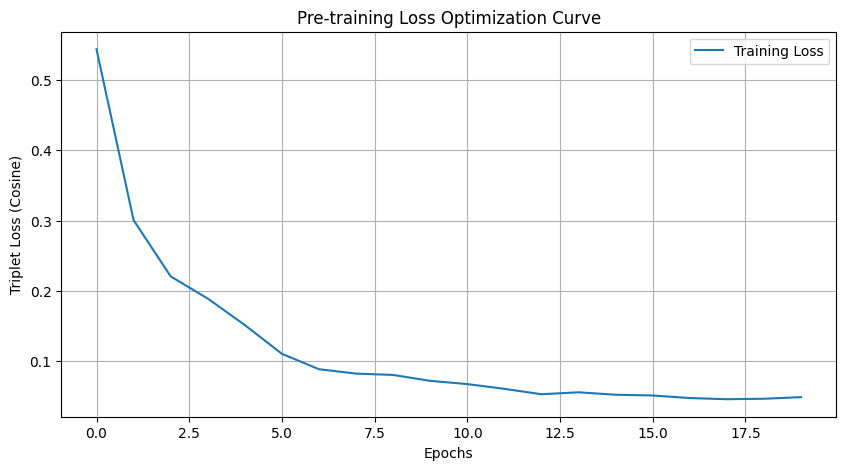

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss')
plt.title('Pre-training Loss Optimization Curve')
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss (Cosine)')
plt.legend()
plt.grid(True)
plt.show()